# 35.6 Challenge - Time Series Analysis
___
Using a different time series data set (either from FRED or elsewhere, go about the process of time series modeling. Specifically generate the following things:

1. Plot the time series, along with any logical or necessary differences to get a stationary dataset
2. Generate and interpret a PACF for the time series (and/or its differences)
3. Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data
4. Finally choose one specification and make the case for that as a logical model for your dataset.


### The Data
___
<br></br>
The data set I will be looking at is historical pork prices and it can be found [here](https://www.indexmundi.com/commodities/?commodity=pork&months=360).

In [33]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import mplcyberpunk

from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [3]:
swine = pd.read_csv('swine_price.csv', parse_dates=['Month'], index_col='Month')

swine.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
swine.head()

,Price,Change
Month,,
1990-04-01,99.64,-
1990-05-01,115.68,16.10 %
1990-06-01,121.46,5.00 %
1990-07-01,96.19,-20.81 %
1990-08-01,93.97,-2.31 %


In [6]:
# Taking a section of the data for 15 years
years_15 = swine[(swine.index >= '1999-01-01')&(swine.index < '2015-01-01')]

years_15.head()

,Price,Change
Month,,
1999-01-01,34.86,82.51 %
1999-02-01,37.34,7.11 %
1999-03-01,35.08,-6.05 %
1999-04-01,39.45,12.46 %
1999-05-01,48.75,23.57 %


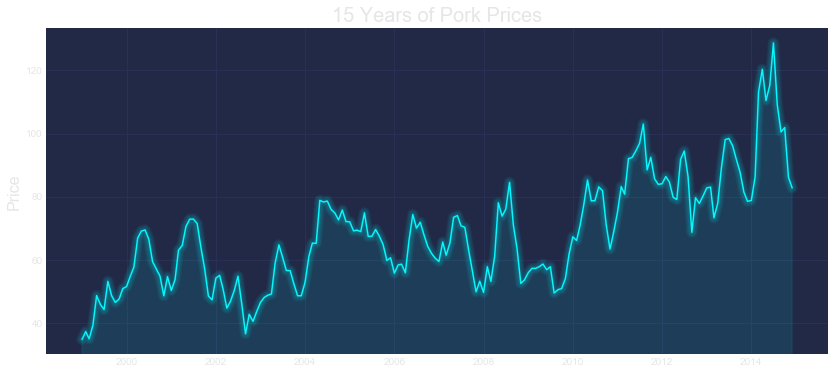

In [7]:
# Plotting graph
plt.figure(figsize=(14,6))
plt.style.use('cyberpunk')
plt.plot(years_15.index, years_15.Price)
plt.ylabel('Price', fontsize=16)
plt.title('15 Years of Pork Prices', fontsize=20)

mplcyberpunk.add_glow_effects()

### Differencing for Stationary Data
---

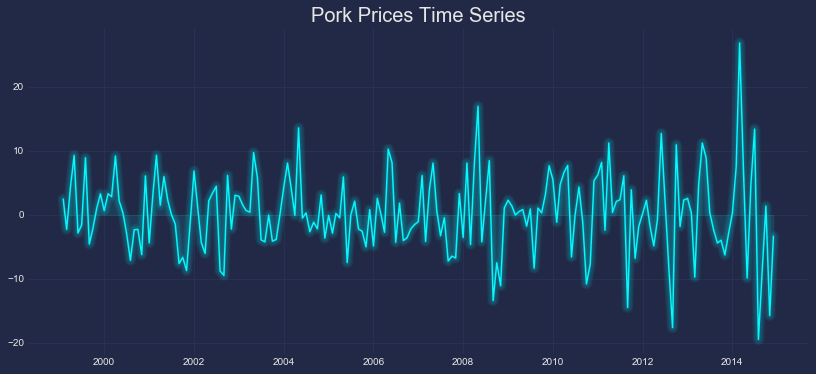

In [14]:
years_15['diff_1'] = years_15.Price - years_15.Price.shift()

plt.figure(figsize=(14,6))
plt.style.use('cyberpunk')

plt.plot(years_15.index, years_15.diff_1)
plt.title('Pork Prices Time Series', fontsize=20)

mplcyberpunk.add_glow_effects()

### Finding Autocorrelation
---

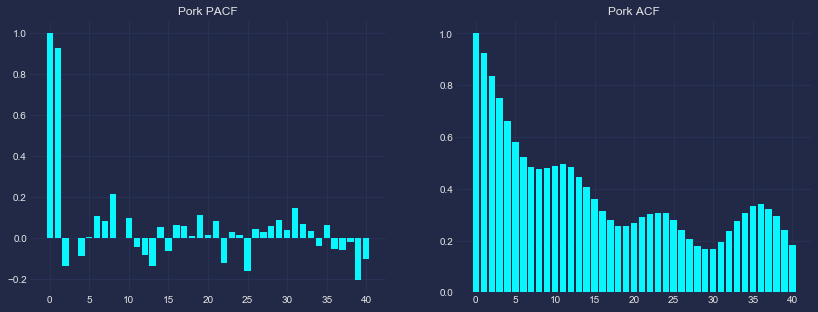

In [23]:
# Plotting ACF and PACF for the dataset
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
x_pacf = pd.DataFrame(pacf(years_15.Price))
x_acf = pd.DataFrame(acf(years_15.Price))

ax1.bar(x_pacf.index, x_pacf[0])
ax1.set(title="Pork PACF");

ax2.bar(x_acf.index, x_acf[0])
ax2.set(title="Pork ACF");

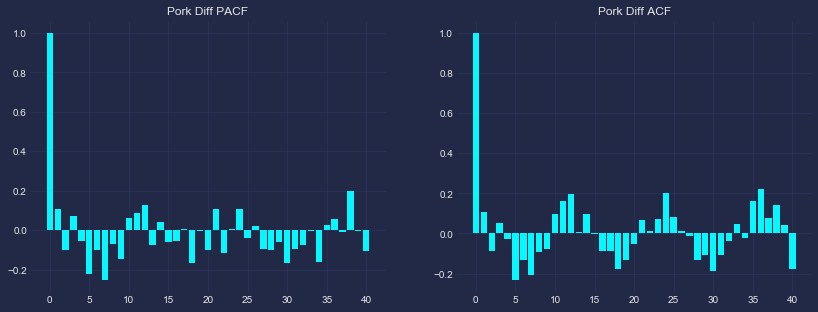

In [27]:
# Plotting ACF and PACF for the differences
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
x_pacf = pd.DataFrame(pacf(years_15.diff_1[1:]))
x_acf = pd.DataFrame(acf(years_15.diff_1[1:]))

ax1.bar(x_pacf.index, x_pacf[0])
ax1.set(title="Pork Diff PACF");

ax2.bar(x_acf.index, x_acf[0])
ax2.set(title="Pork Diff ACF");

The differences here do not seem to show any autocorrelation, but the intial time series seems to show strong PACF at 1 and the ACF seems to show potentially significant autocorrelation up to 10.

### Gridsearch ARIMA Models
---
<br></br>
Let's build a grid search function based on the ACF/PACF numbers to find an optimum ARIMA model

ARIMA(0, 0, 0) AIC=1643.009 Log-liklihood: -819.504
ARIMA(0, 0, 1) AIC=1463.077 Log-liklihood: -728.538
ARIMA(0, 0, 2) AIC=1364.132 Log-liklihood: -678.066
ARIMA(0, 1, 0) AIC=1245.095 Log-liklihood: -620.547
ARIMA(0, 1, 1) AIC=1244.463 Log-liklihood: -619.231
ARIMA(0, 1, 2) AIC=1244.680 Log-liklihood: -618.340
ARIMA(1, 0, 0) AIC=1250.696 Log-liklihood: -622.348
ARIMA(1, 0, 1) AIC=1248.159 Log-liklihood: -620.079
ARIMA(1, 0, 2) AIC=1249.606 Log-liklihood: -619.803
ARIMA(1, 1, 0) AIC=1244.982 Log-liklihood: -619.491
ARIMA(1, 1, 1) AIC=1245.219 Log-liklihood: -618.609
ARIMA(1, 1, 2) AIC=1246.676 Log-liklihood: -618.338
ARIMA(2, 0, 0) AIC=1248.714 Log-liklihood: -620.357
ARIMA(2, 0, 1) AIC=1249.509 Log-liklihood: -619.755
ARIMA(2, 0, 2) AIC=1251.480 Log-liklihood: -619.740
ARIMA(2, 1, 0) AIC=1245.133 Log-liklihood: -618.566
ARIMA(2, 1, 1) AIC=1246.503 Log-liklihood: -618.251
ARIMA(2, 1, 2) AIC=1244.465 Log-liklihood: -616.233
ARIMA(10, 0, 0) AIC=1238.744 Log-liklihood: -607.372
ARIMA(10, 0

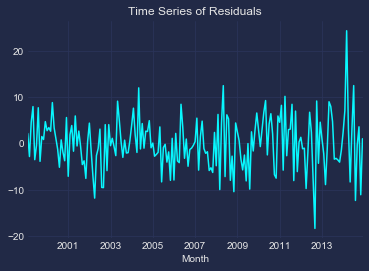

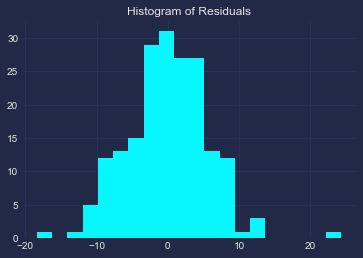

In [47]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_aic, worst_aic, best_cfg, worst_config, best_llf = float("inf"), float("-inf"), None, None, 0
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit()
                    llf = model_fit.llf
                    aic = model_fit.aic

                    if aic < best_aic:
                        best_aic, best_cfg, best_llf = aic, order, llf
                    
                    if aic > worst_aic:
                        worst_aic, worst_cfg = aic, order
                        
                    print(f'ARIMA{order} AIC={aic:.3f} Log-liklihood: {llf:.3f}')
                except:
                    continue
    print(f'Best ARIMA: {best_cfg}    AIC: {best_aic:.3f}    Log-liklihood: {best_llf:.3f}')
    print('-' * 50)
    best_model = ARIMA(years_15.Price, order=best_cfg)
    best_model_fit = best_model.fit()
    print(best_model_fit.summary())
    print('-' * 50)
    print('\n')
    print('Best v Worst Comparison')
    print(f'Best AIC: {best_aic}')
    print(f'Worst AIC: {worst_aic}')
    print(math.exp((best_aic - worst_aic)/2))
    print('-' * 50)
    print('\n')
    print('Residuals Description')
    print(best_model_fit.resid.describe())
    residuals = pd.DataFrame(best_model_fit.resid)
    residuals.plot(legend=False)
    plt.title('Time Series of Residuals')
    residuals.hist(bins=20)
    plt.title('Histogram of Residuals')
    
p_values = [0, 1, 2, 10]
d_values = [0,1]
q_values = range(0, 3)

evaluate_models(years_15.Price, p_values, d_values, q_values)

### Conclusion
---

There is a lot to unpack here.

1. 10,1,0 looks to be our best model, but the p values for the constant and the majority of the AR values are not significant. Base on the subject matter, there may be some seasonality that we are missing. Potentially SARIMA may be helpful in this situation, but it is out of the scope of this project.
2. Compared to the worst model, the best model shows promise.
3. When considering the residuals, there doesn't seem to be a clear trend to the data, but as mentioned before, there may be some seasonality that we are missing.
4. The residuals also seem to be evenly distributed and the mean is close to zero